<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

In [ ]:
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [ ]:
with pm.Model(coords=aa_coords) as cs_ST_model:
    #hyperpriors
    μ_mu = pm.StudentT('μ_mu', nu=1,mu=0,sigma=10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=1, sigma = 10)
    μ_nu = pm.HalfStudentT('μ_nu', nu=1, sigma = 10)

    # priors
    μ = pm.StudentT('μ',
                  nu = μ_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")
    σ = pm.HalfStudentT('σ', nu=1, sigma = 10,
                      dims = "aa")
    #likelihood
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)
    idata_cs_ST = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_N_model:
    # hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")
    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")
    #likelihood
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)
    idata_cs_N = pm.sample()

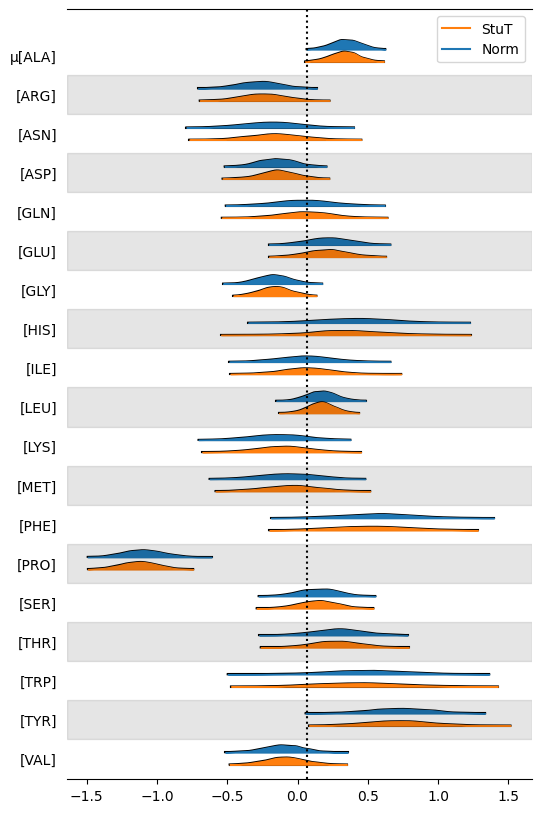

In [ ]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_N, idata_cs_ST], kind="ridgeplot", model_names=["Norm", "StuT"],
                      var_names='μ', combined=True, figsize=(6, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_N.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

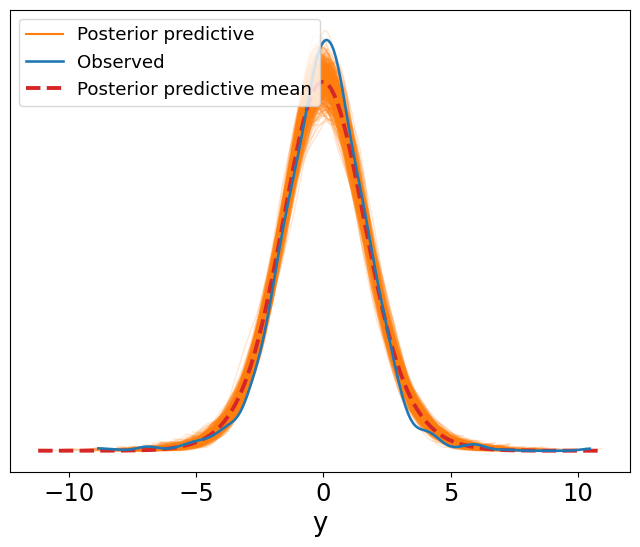

In [ ]:
pm.sample_posterior_predictive(idata_cs_ST, model=cs_ST_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_ST, num_pp_samples=500, figsize=(8, 6), colors=["C1", "C0", "C3"])

Output()

<Axes: xlabel='y'>

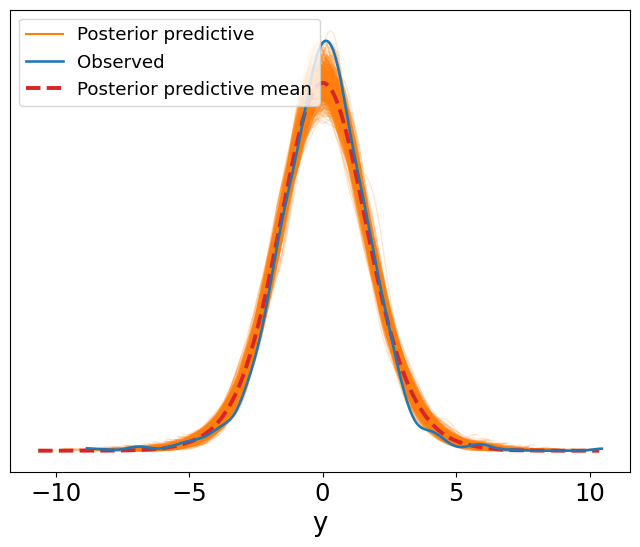

In [ ]:
pm.sample_posterior_predictive(idata_cs_N, model=cs_N_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_N, num_pp_samples=500, figsize=(8, 6), colors=["C1", "C0", "C3"])

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [4]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ = pm.Beta('μ', mu = 1/11, nu = 55, dims = "pos")
    ν = pm.Gamma('ν', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

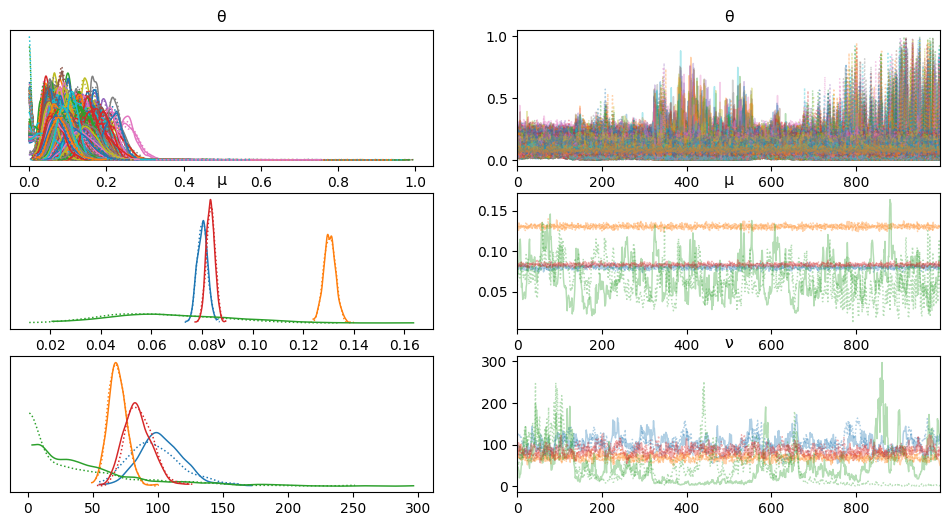

In [ ]:
az.plot_trace(idata_sccr)

In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.006 1.005 ... 1.006 0.9997 0.9997
    μ        (pos) float64 32B 1.002 1.0 1.032 1.001
    ν        (pos) float64 32B 1.015 0.9995 1.146 1.005

For most of these, it becomes even more evident that goal keeper is an outlier. The rhat for GK increased dramatically, while the others have minimal change. The graphs now are actually tighter, showing imporvement (this is most evident my the ticks on the side of each figure).

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

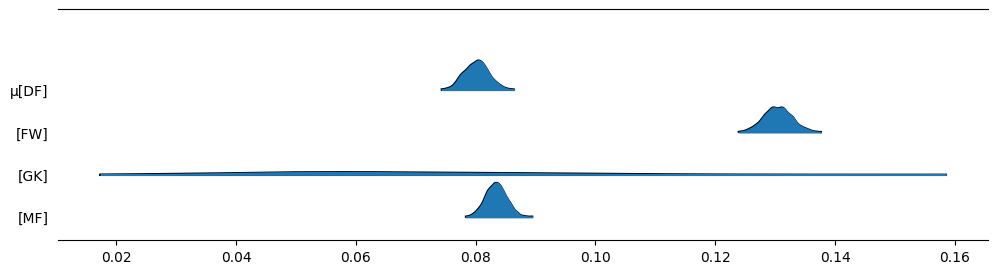

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [35]:
url_sccr1 = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data1 = pd.read_csv(url_sccr1)

In [36]:
nGKData = sccr_data1.query('position != "GK"')
nGKData

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [39]:
pos_encode1 = pd.Categorical(nGKData['position'])
pos_idx1 = pos_encode1.codes
sccr_coords1 = {"pos": pos_encode1.categories}

In [ ]:
with pm.Model(coords = sccr_coords1) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx1], nu = ν_p[pos_idx1])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = nGKData.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = nGKData.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr1 = pm.sample(target_accept = 0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

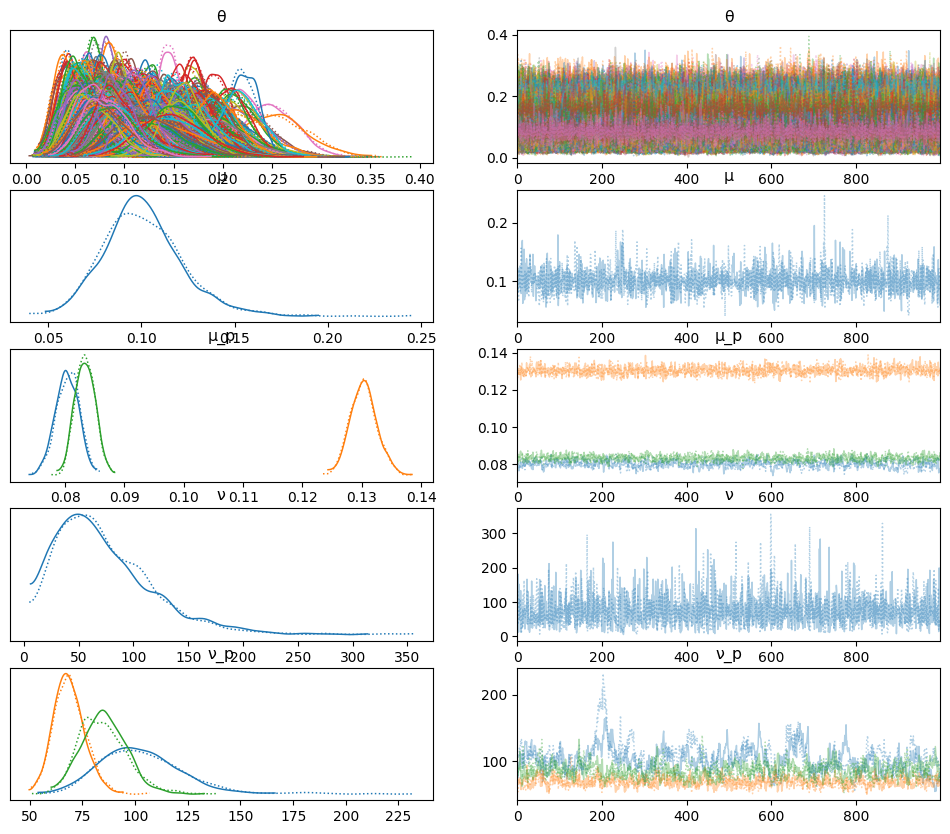

In [41]:
az.plot_trace(idata_sccr1)

In [44]:
az.rhat(idata_sccr1)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.004 1.0 1.001 1.0 ... 0.9997 1.0 1.004 1.0
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.002 1.001 1.003
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.025 1.004 1.017

Based on runtime alone, no GK one was easier for pymc. For the most part, the data has turned out nicer as well. The rhat is also pretty healthy.